<font size="6" style="color:#ce4257">AMEX : EDA</font>

<font size="5" style="color:#219ebc">Table of contents</font>

- [Introduction](#1)

- [Data Overview](#2)

- [Features correlations](#3)

- [Feature distribution](#4)

- [Missing data](#6)

- [Target distribution and correlations](#7)

In [1]:
%%capture --no-display
import pandas as pd 
import numpy as np 

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import colors,ListedColormap, LinearSegmentedColormap,rgb2hex 

<font size="5" style="color:#219ebc">1. Introduction</font>
<div id="1">
    
- Default risk is the probability that if you lend money, there is a chance that the borrowers won’t be able to give the money back on time. 

- Lenders and investors are exposed to default risk in virtually all forms of credit extensions. 
    
- The objective is to predict the probability that a customer does not pay back their credit card balance in the future based on their monthly customer profile.
    
- There are a total of 190 features in the dataset with approximately 450,000 unique customers and over 5 million data points.

In [2]:
def get_colormap(N:int):
    """
        Returns a rgb and hex cyan to pink colormap with the specified number of segmentations.
    """
    rgb_colors = LinearSegmentedColormap.from_list('my_colormap',
                                    ['#bbd5de','#6495ed','#ff355d'],
                                    N=N)
    hex_colors = [rgb2hex(rgb_colors(i)) for i in range(rgb_colors.N)]
    return rgb_colors,hex_colors

In [3]:
TRAIN_CSV = '../input/amexfeather/train_data.ftr'

In [4]:
train_df = pd.read_feather(TRAIN_CSV)
train_df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0


In [5]:
train_df['customer_ID'].nunique()

458913

<font size="5" style="color:#219ebc">2. Data Overview</font>
<div id="2">
The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. 

Features are anonymized and normalized, and fall into the following general categories:

- D_*: Delinquency variables
- S_*: Spend variables
- P_*: Payment variables
- B_*: Balance variables
- R_*: Risk variables

With the following features being categorical: D_63, D_64, D_66, D_68, B_30, B_38, D_114, D_116, D_117, D_120, D_126.

Although they repressent only 7% of the total training set , 93% of features are numerical.



In [6]:
train_df.select_dtypes(include='category').columns

Index(['D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116',
       'D_117', 'D_120', 'D_126'],
      dtype='object')

In [7]:
def plot_pie(data:pd.Series,title:str,size:int,ax=None) -> None:
    """
        Plot class distribution pie chart of a categorical varable.
    """
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.set_title(title,fontsize=24,color='#555555')
    data.plot(kind='pie',
                      figsize=(size,size),
                      colormap=get_colormap(60)[0],
                      explode=[i*0.12 for i in range(0,len(data))],
                      pctdistance=1.15,
                      labeldistance=None,
                     ax=ax).get_yaxis().set_visible(False)
    ax.legend(fontsize=12)
    labels = data.index
    perc = data.values*100/data.values.sum()
    labels = [f'{label}: {value:0.2f}%' for label,value in zip(labels,perc)]
    ax.legend(labels=labels,fontsize=11)

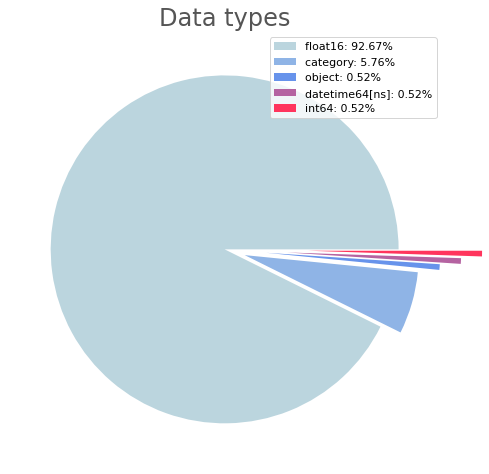

In [8]:
dtypes_counts = train_df.sample(10000).dtypes.astype(str).value_counts()
plot_pie(dtypes_counts,'Data types',8)
del dtypes_counts

<font size="5" style="color:#219ebc">Check duplicates</font>

In [9]:
train_df.duplicated().any()

False

<font size="5" style="color:#219ebc">Check features correlations</font>
<div id="3">
There are several highly correlated variables, with 11 out of 190 almost perfectly correlated at 1 or -1. 

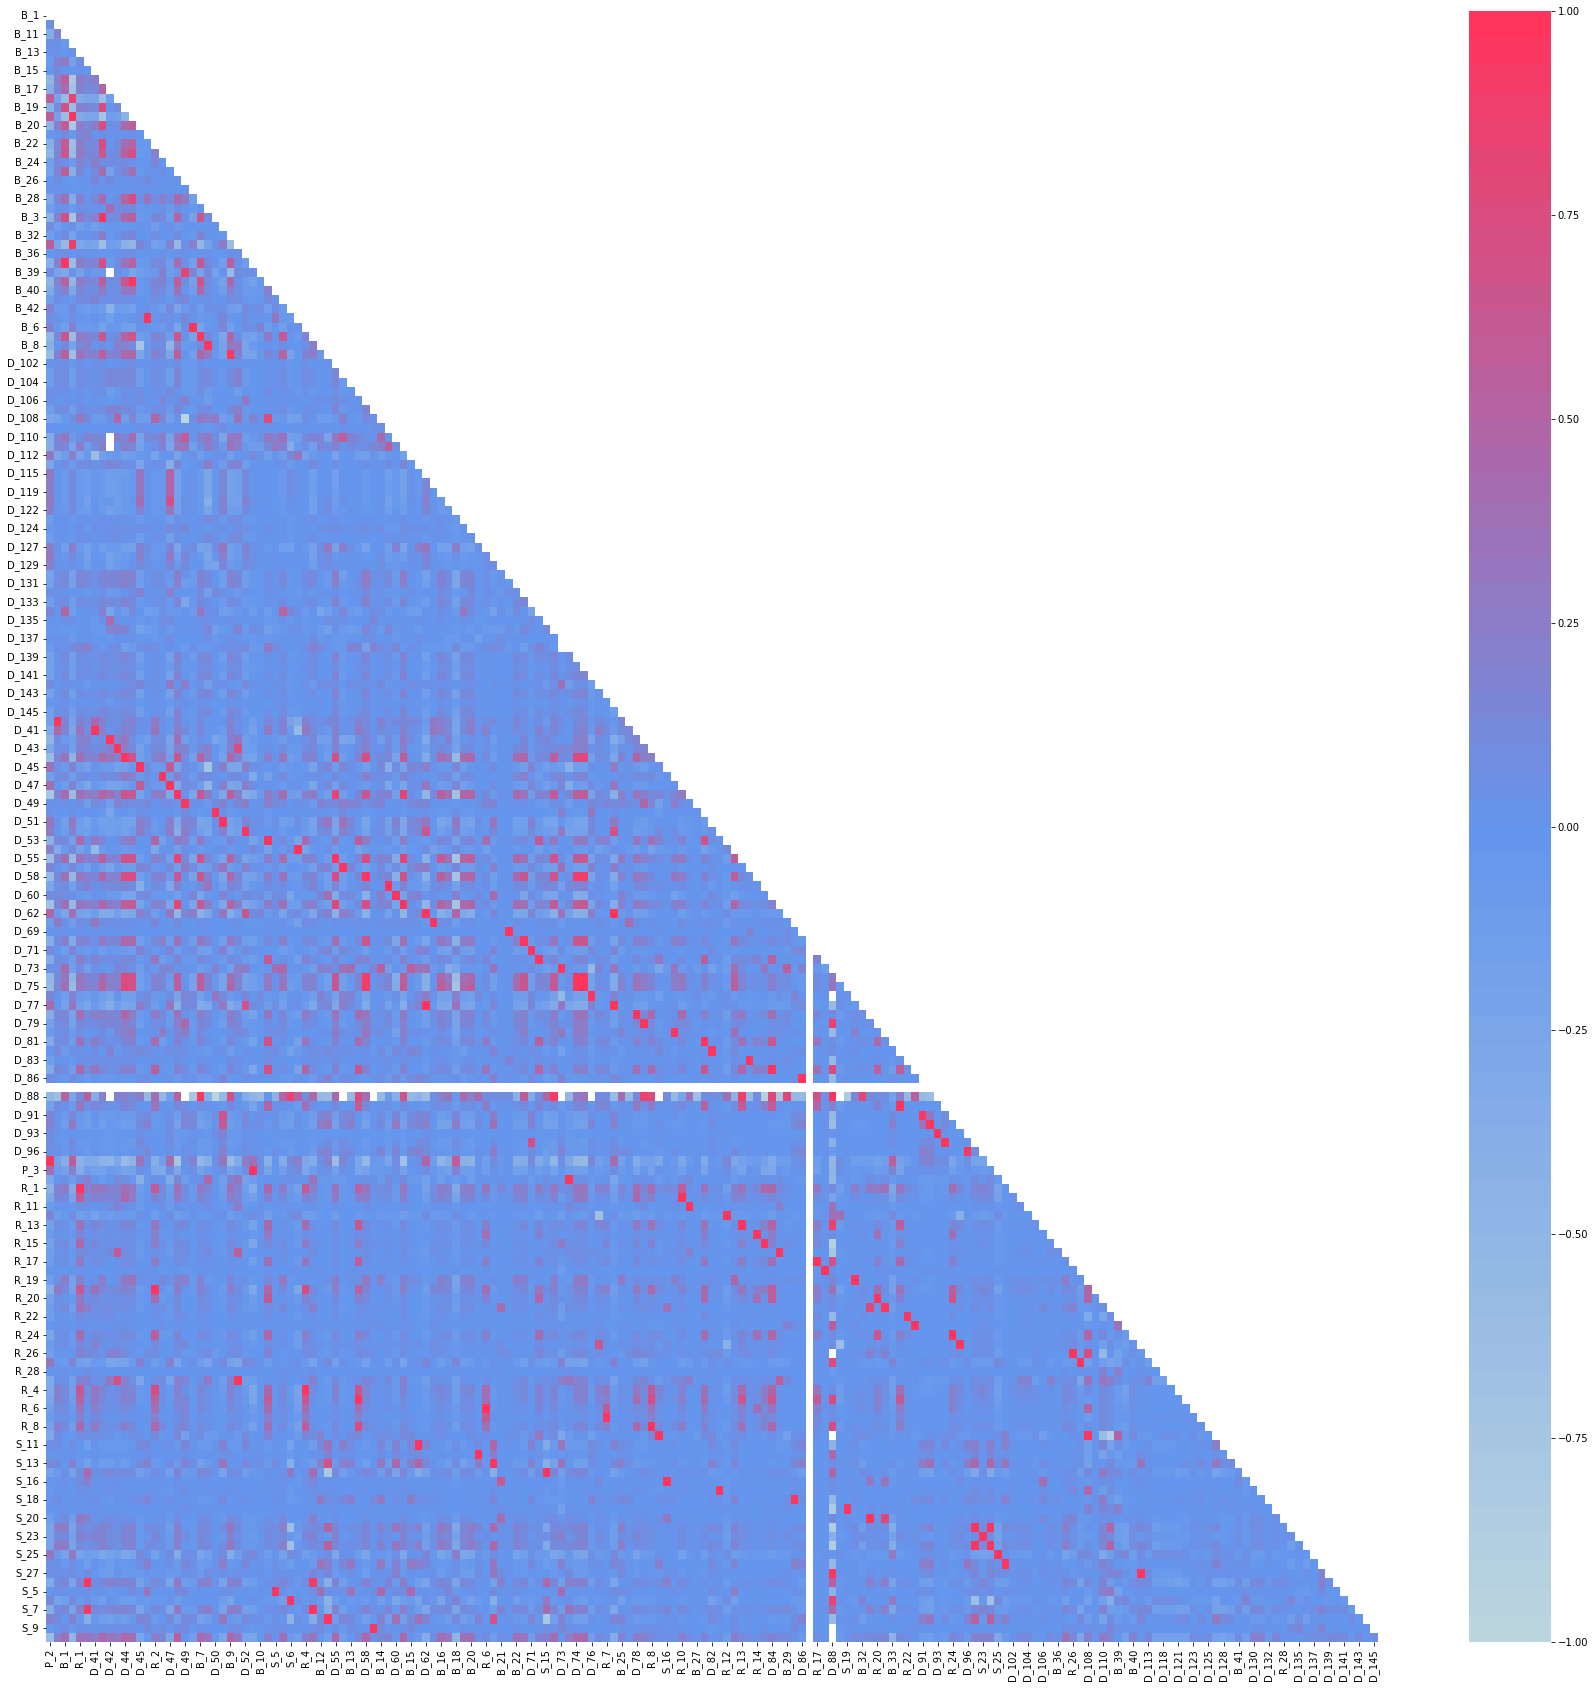

In [10]:
def plot_all_correlations(df:pd.DataFrame)->None: 
    plt.figure(figsize=(30,30))
    cols = df.columns.to_list()
    corr = df.sample(10000).corr().sort_index()
    diagonal_mask=np.triu(corr)# show only lower diagonal values
    sb.heatmap(corr,cmap=get_colormap(60)[0],mask=diagonal_mask,)
    plt.show()
    
plot_all_correlations(train_df)

In [11]:
def get_numerical_correlated(df:pd.DataFrame,thresh:float=0.99)->list:  
    """
        Returns a list containing the features that have a linear correlation greater than the specified threshold.
    """
    high_correlated_features=[]
    df = df.select_dtypes(include=np.number)
    corr=df.sample(10000).corr()
    for feature in range(len(corr)):
        for other_feature in range(len(corr)):
            
            if feature!=other_feature and \
               df.columns[other_feature] not in high_correlated_features and \
               abs(corr.iloc[feature][other_feature]) >= thresh:
                
                print(f"{df.columns[feature]} and {df.columns[other_feature]} are highly correlated ({corr.iloc[feature][other_feature]:.3f})") 
                high_correlated_features.append(df.columns[feature])
                break
    return high_correlated_features      

get_numerical_correlated(train_df,0.99)

B_1 and B_11 are highly correlated (0.996)
B_7 and B_23 are highly correlated (0.995)
D_62 and D_77 are highly correlated (1.000)
B_17 and D_73 are highly correlated (-1.000)
D_73 and D_88 are highly correlated (-1.000)
R_9 and D_88 are highly correlated (1.000)
B_29 and D_110 are highly correlated (1.000)
D_88 and R_26 are highly correlated (1.000)
D_103 and D_104 are highly correlated (1.000)
D_108 and B_42 are highly correlated (-1.000)
D_118 and D_119 are highly correlated (0.995)
B_42 and D_134 are highly correlated (-1.000)
D_139 and D_141 are highly correlated (0.998)
D_141 and D_143 are highly correlated (0.998)


['B_1',
 'B_7',
 'D_62',
 'B_17',
 'D_73',
 'R_9',
 'B_29',
 'D_88',
 'D_103',
 'D_108',
 'D_118',
 'B_42',
 'D_139',
 'D_141']

<font size="5" style="color:#219ebc">Categorical features distribution</font>
<div id="4">
    
- It seems like all categorical features are correctly labeled with no apparent duplicates.

- Distributions between classes are all highly unequally.

- Every feature has at most eight categories (including nan values). One-hot encodings are feasible.

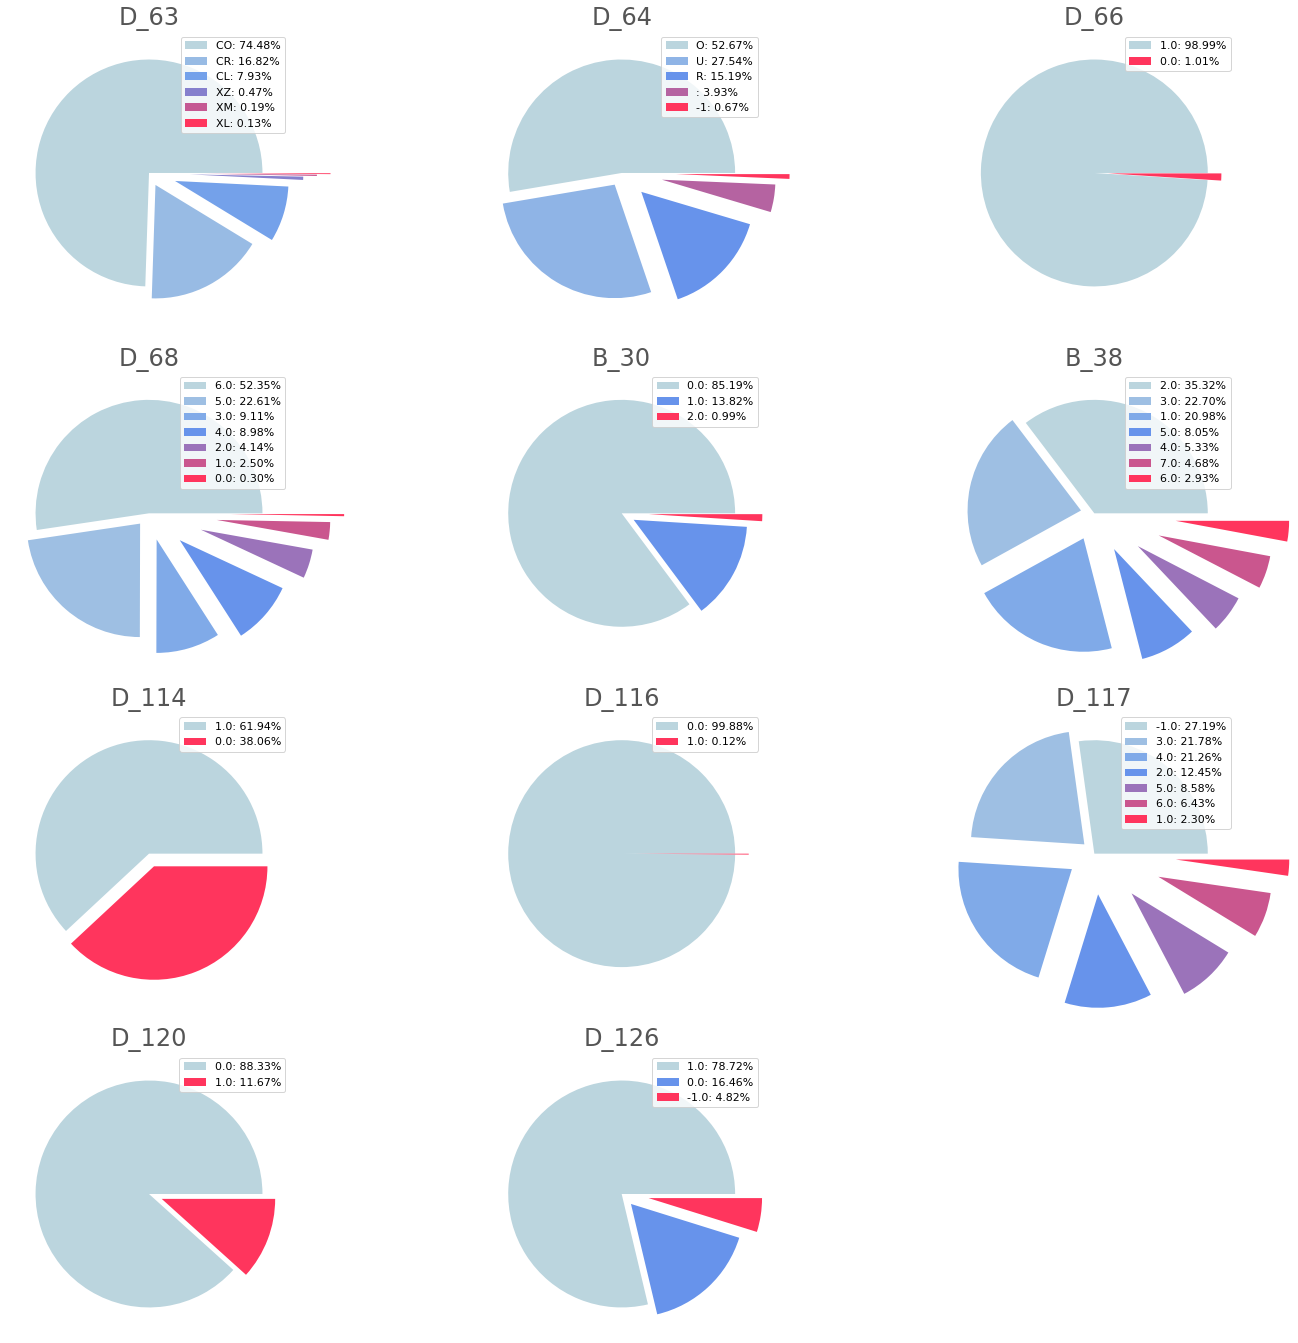

In [12]:
cat_train_df = train_df.select_dtypes(include=['category'])
fig, axs = plt.subplots(4,int(len(cat_train_df.columns)/4) + 1)
axs[-1,-1].axis('off')
for i,col in enumerate(cat_train_df.columns):
    plot_pie(train_df.select_dtypes(include=['category'])[col].value_counts(),col,24,axs[i//3,i%3])
    
del cat_train_df,fig,axs

<font size="5" style="color:#219ebc">Continuous features distributions</font>

- We see that they have all kinds of distributions
- There are some density plots that show extreme dispersion, that might be an indication of outliers.

In [13]:
def density_plot(df:pd.DataFrame, title:str, hex_colormap:list=get_colormap(2)[1])->None:     
    """
        Plots density function of all numerical features with a targuet based color mapping.
    """
    features = df.select_dtypes(include=np.number).columns
    n_cols = 6
    n_rows = len(features)//n_cols
    if (len(features)<6):
        n_cols= len(features)-1
        n_rows=1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*2), sharey=False)
    
    #fig.subplots_adjust(top=0.90)
    for i in range (n_rows*n_cols):
        feature = df.select_dtypes(include=np.number).columns[i]
        plt.subplot(n_rows,n_cols, i+1)
        ax = sb.kdeplot(data=df.sample(1000),x=feature,hue='target',palette=hex_colormap,warn_singular=False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_label_position('top')   
        ax.set_ylabel('')
        ax.set_yticks([])        
        ax.set_xticks([])

    plt.suptitle(title, fontsize=20,y=0.9+0.2/n_rows)
    plt.show()

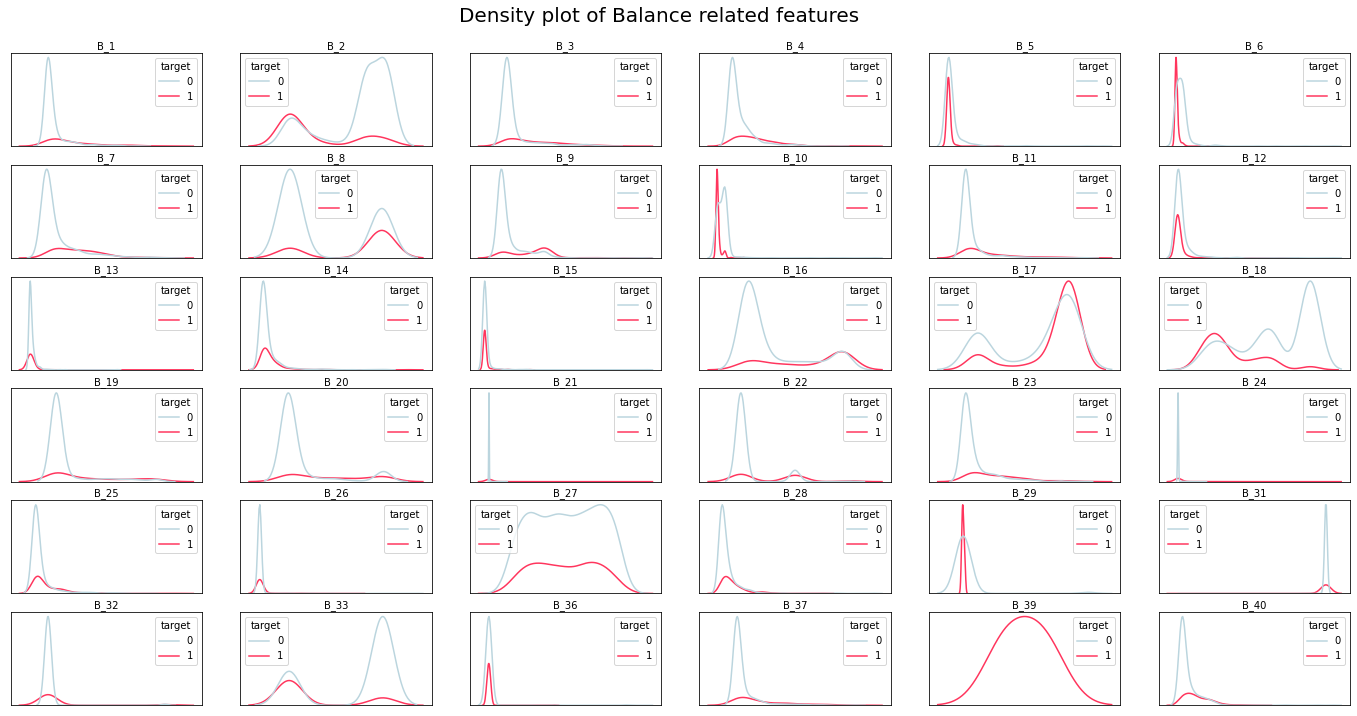

In [14]:
density_plot(train_df.loc[:,(train_df.columns.str.startswith("B"))|(train_df.columns.str.fullmatch('target'))], title='Density plot of Balance related features')

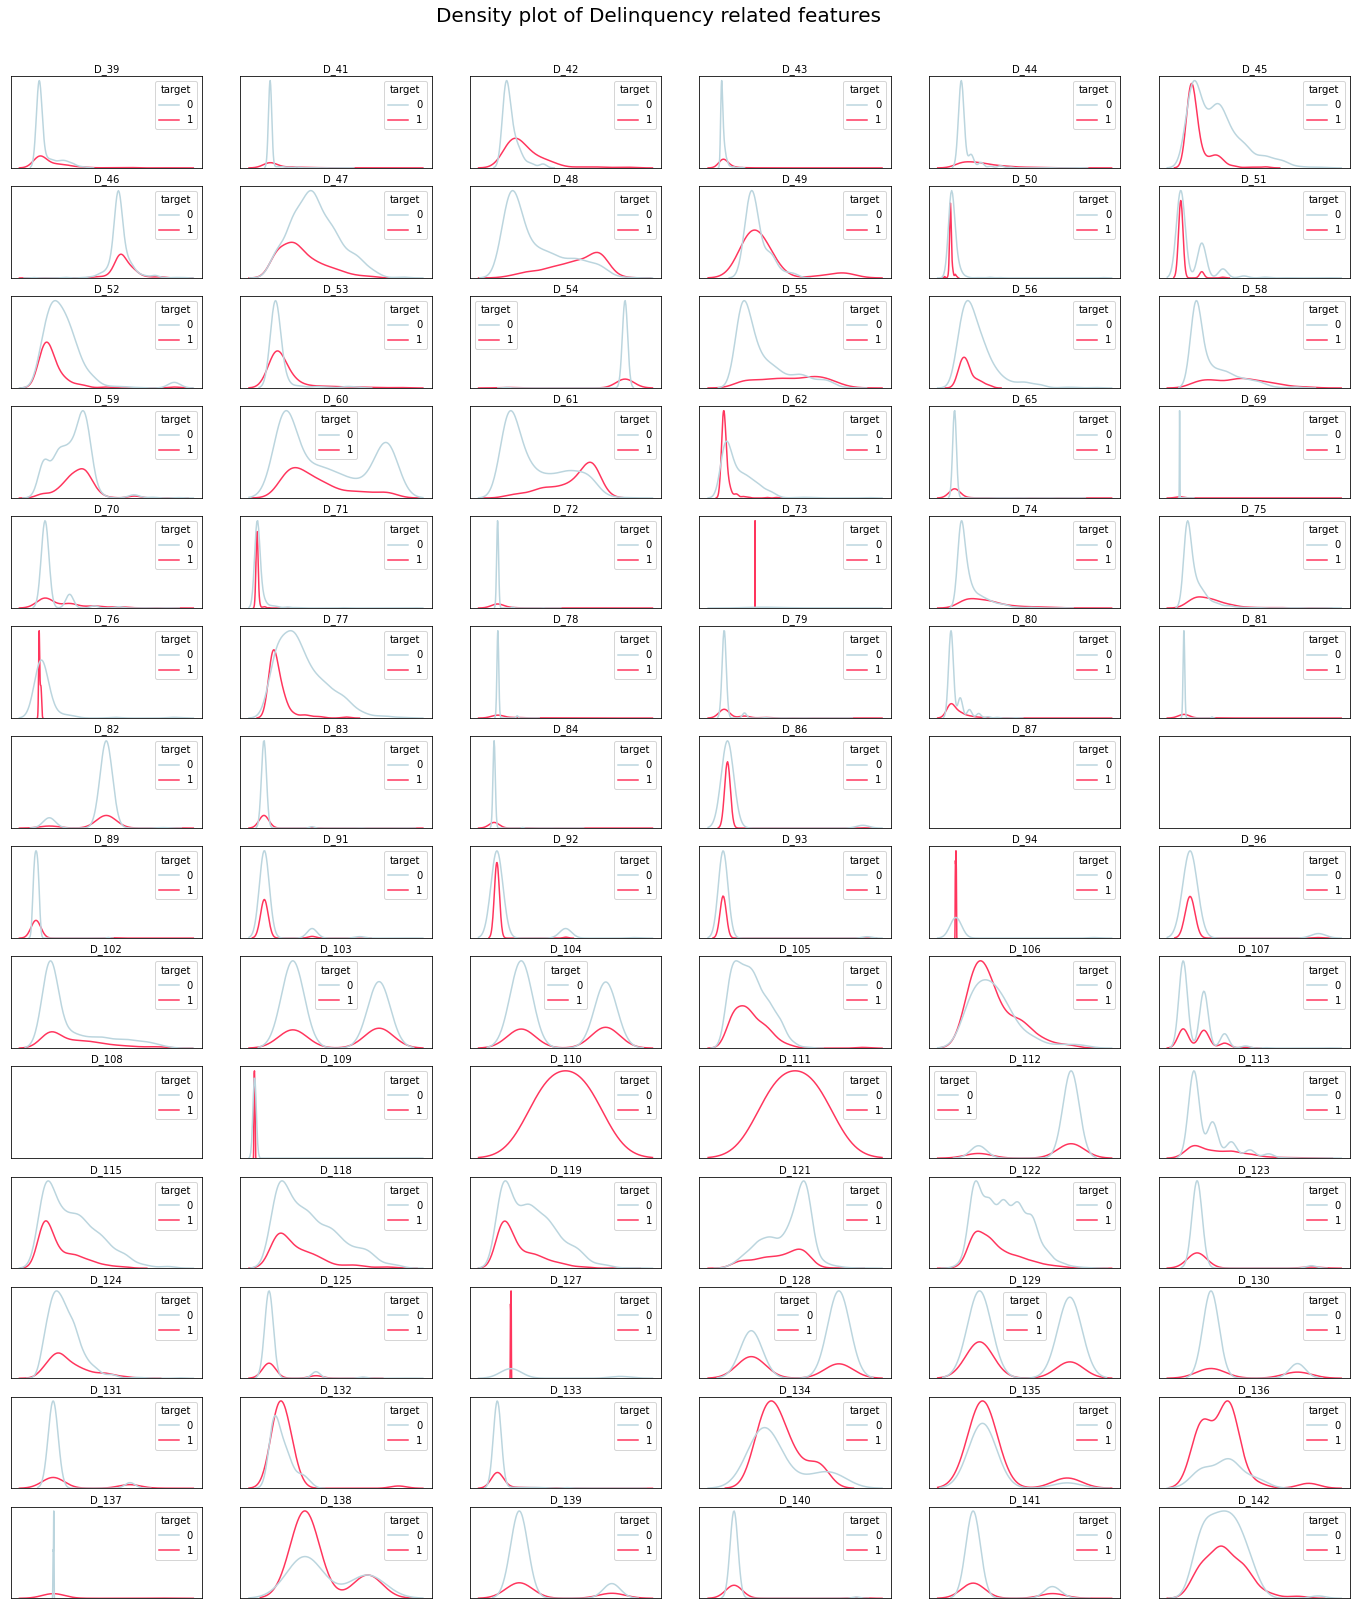

In [15]:
density_plot(train_df.loc[:,(train_df.columns.str.startswith("D"))|(train_df.columns.str.fullmatch('target'))], title='Density plot of Delinquency related features')

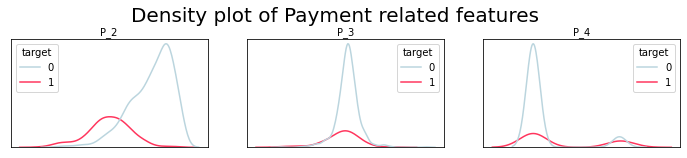

In [16]:
density_plot(train_df.loc[:,(train_df.columns.str.startswith("P"))|(train_df.columns.str.fullmatch('target'))], title='Density plot of Payment related features')

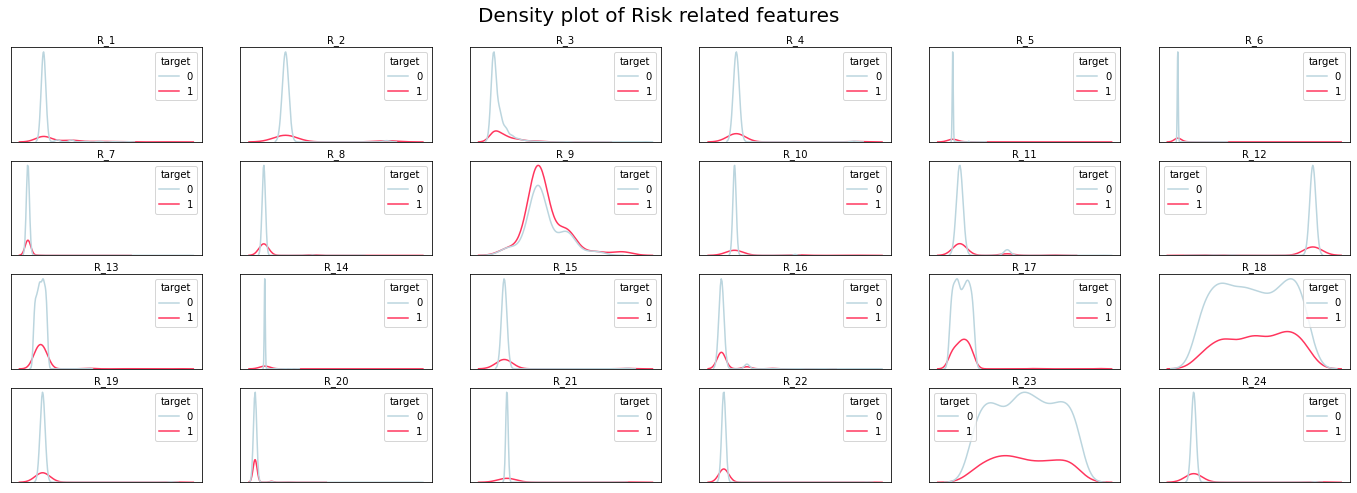

In [17]:
density_plot(train_df.loc[:,(train_df.columns.str.startswith("R"))|(train_df.columns.str.fullmatch('target'))], title='Density plot of Risk related features')

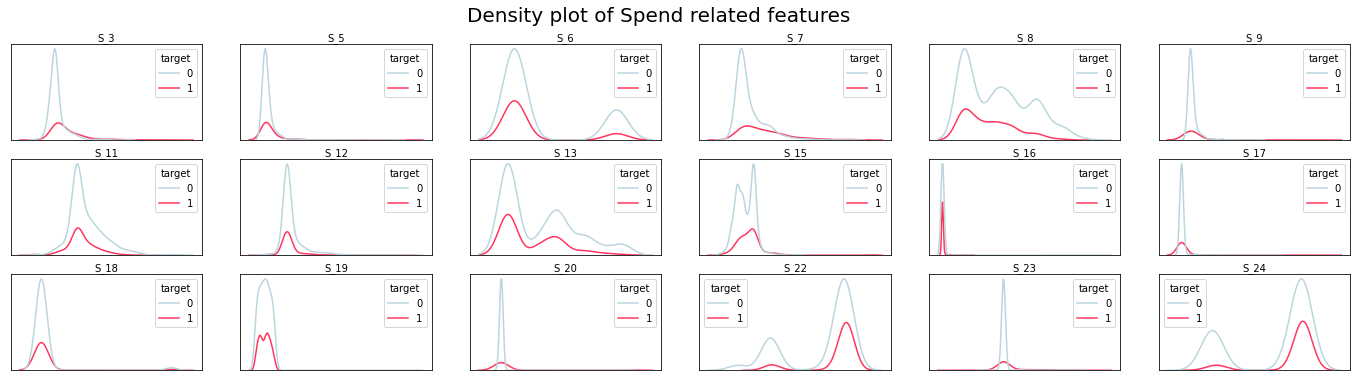

In [18]:
density_plot(train_df.loc[:,(train_df.columns.str.startswith("S"))|(train_df.columns.str.fullmatch('target'))], title='Density plot of Spend related features')

<font size="5" style="color:#219ebc">Missing data</font>
<div id="5">
    
Out of the top 30 of missing features there are 24 Delinquency variables with over 80% nan values.

In [19]:
def get_nan_percentajes(df:pd.DataFrame,thresh:int=0)-> pd.DataFrame:
    """
        Returns the nan frequency percetages of features that surpass the specified threshold.
    """
    null_perc = df.isnull().sum().divide(len(df)).multiply(100).to_frame(name='Missing %')
    null_perc = null_perc[null_perc['Missing %']>=thresh].sort_values(by='Missing %')
    return null_perc
    
def plot_nan(df:pd.DataFrame,thresh:int=0,size:int=24)-> None:
    """
        Plot a vertically oriented bar chart of nan fequencey percentages of all features that surpass the specified threshold.
    """
    null_perc = get_nan_percentajes(df,thresh)
    plt.figure(figsize=(size,size))
    sb.set(font_scale=1.1)
    barplot = sb.barplot(x=null_perc['Missing %'],y=null_perc.index,orient='h',palette=get_colormap(len(null_perc))[1])
    barplot.set_title('Percentages of missing columns values',{'fontsize':size})
    #sb.set(font_scale = 2)
    barplot.set_yticks(barplot.get_yticks().tolist() ,size = size//2 + 2)
    barplot.set_xticks(barplot.get_xticks().tolist(), size = size//2 + 2)
    labels = barplot.bar_label(barplot.containers[0],fmt='%.3f')

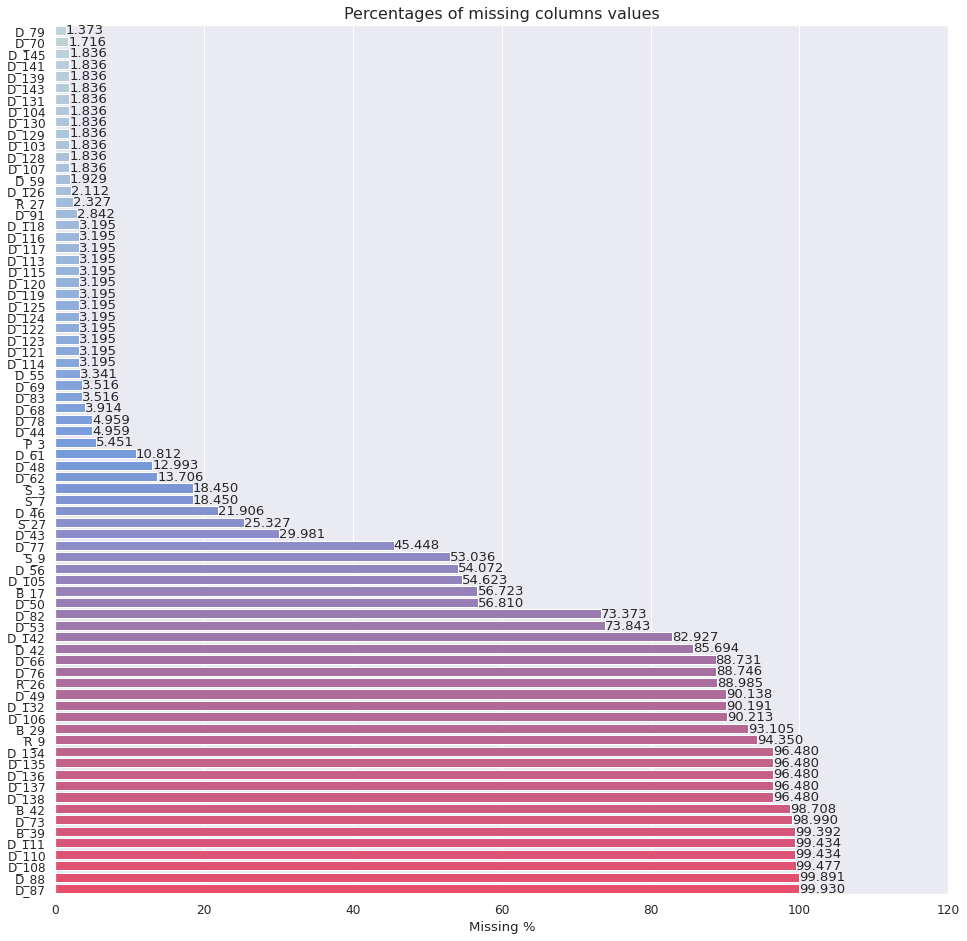

In [20]:
plot_nan(train_df,1,16)

<font size="5" style="color:#219ebc">Target distribution and correlations</font>
<div id="6">
    
- Target distribution is not balanced
    
- There are several strong correlations with the target variable. 

- Payment 2 is the most negatively correlated with the probability of defaulting with a correlation of -0.61, while Delinquency 87 is the most positively correlated overall at 0.55

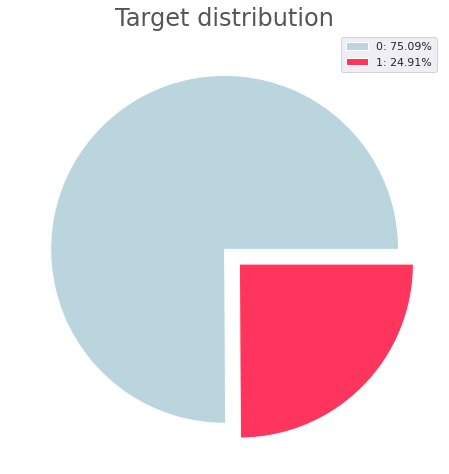

In [21]:
plot_pie(train_df['target'].value_counts(),'Target distribution',8)

In [22]:
def plot_corr(df:pd.DataFrame,corr_feature:str,size:int=34)-> None:
    """
        Plot a vertically oriented bar chart of all linear correlations with the specified feature.
    """
    feature_corr = df.sample(10000).corr()[corr_feature].sort_values().drop(index=corr_feature)
    plt.figure(figsize=(size,size))
    sb.set(font_scale=1.1)
    barplot = sb.barplot(x=feature_corr.values,y=feature_corr.index,orient='h',palette=get_colormap(len(feature_corr))[1])
    barplot.set_title(f'{corr_feature} features correlations',{'fontsize':size})
    #sb.set(font_scale = 2)
    barplot.set_yticks(barplot.get_yticks().tolist() ,size = size//2 + 2)
    barplot.set_xticks(barplot.get_xticks().tolist(), size = size//2 + 2)
    labels = barplot.bar_label(barplot.containers[0],fmt='%.3f')

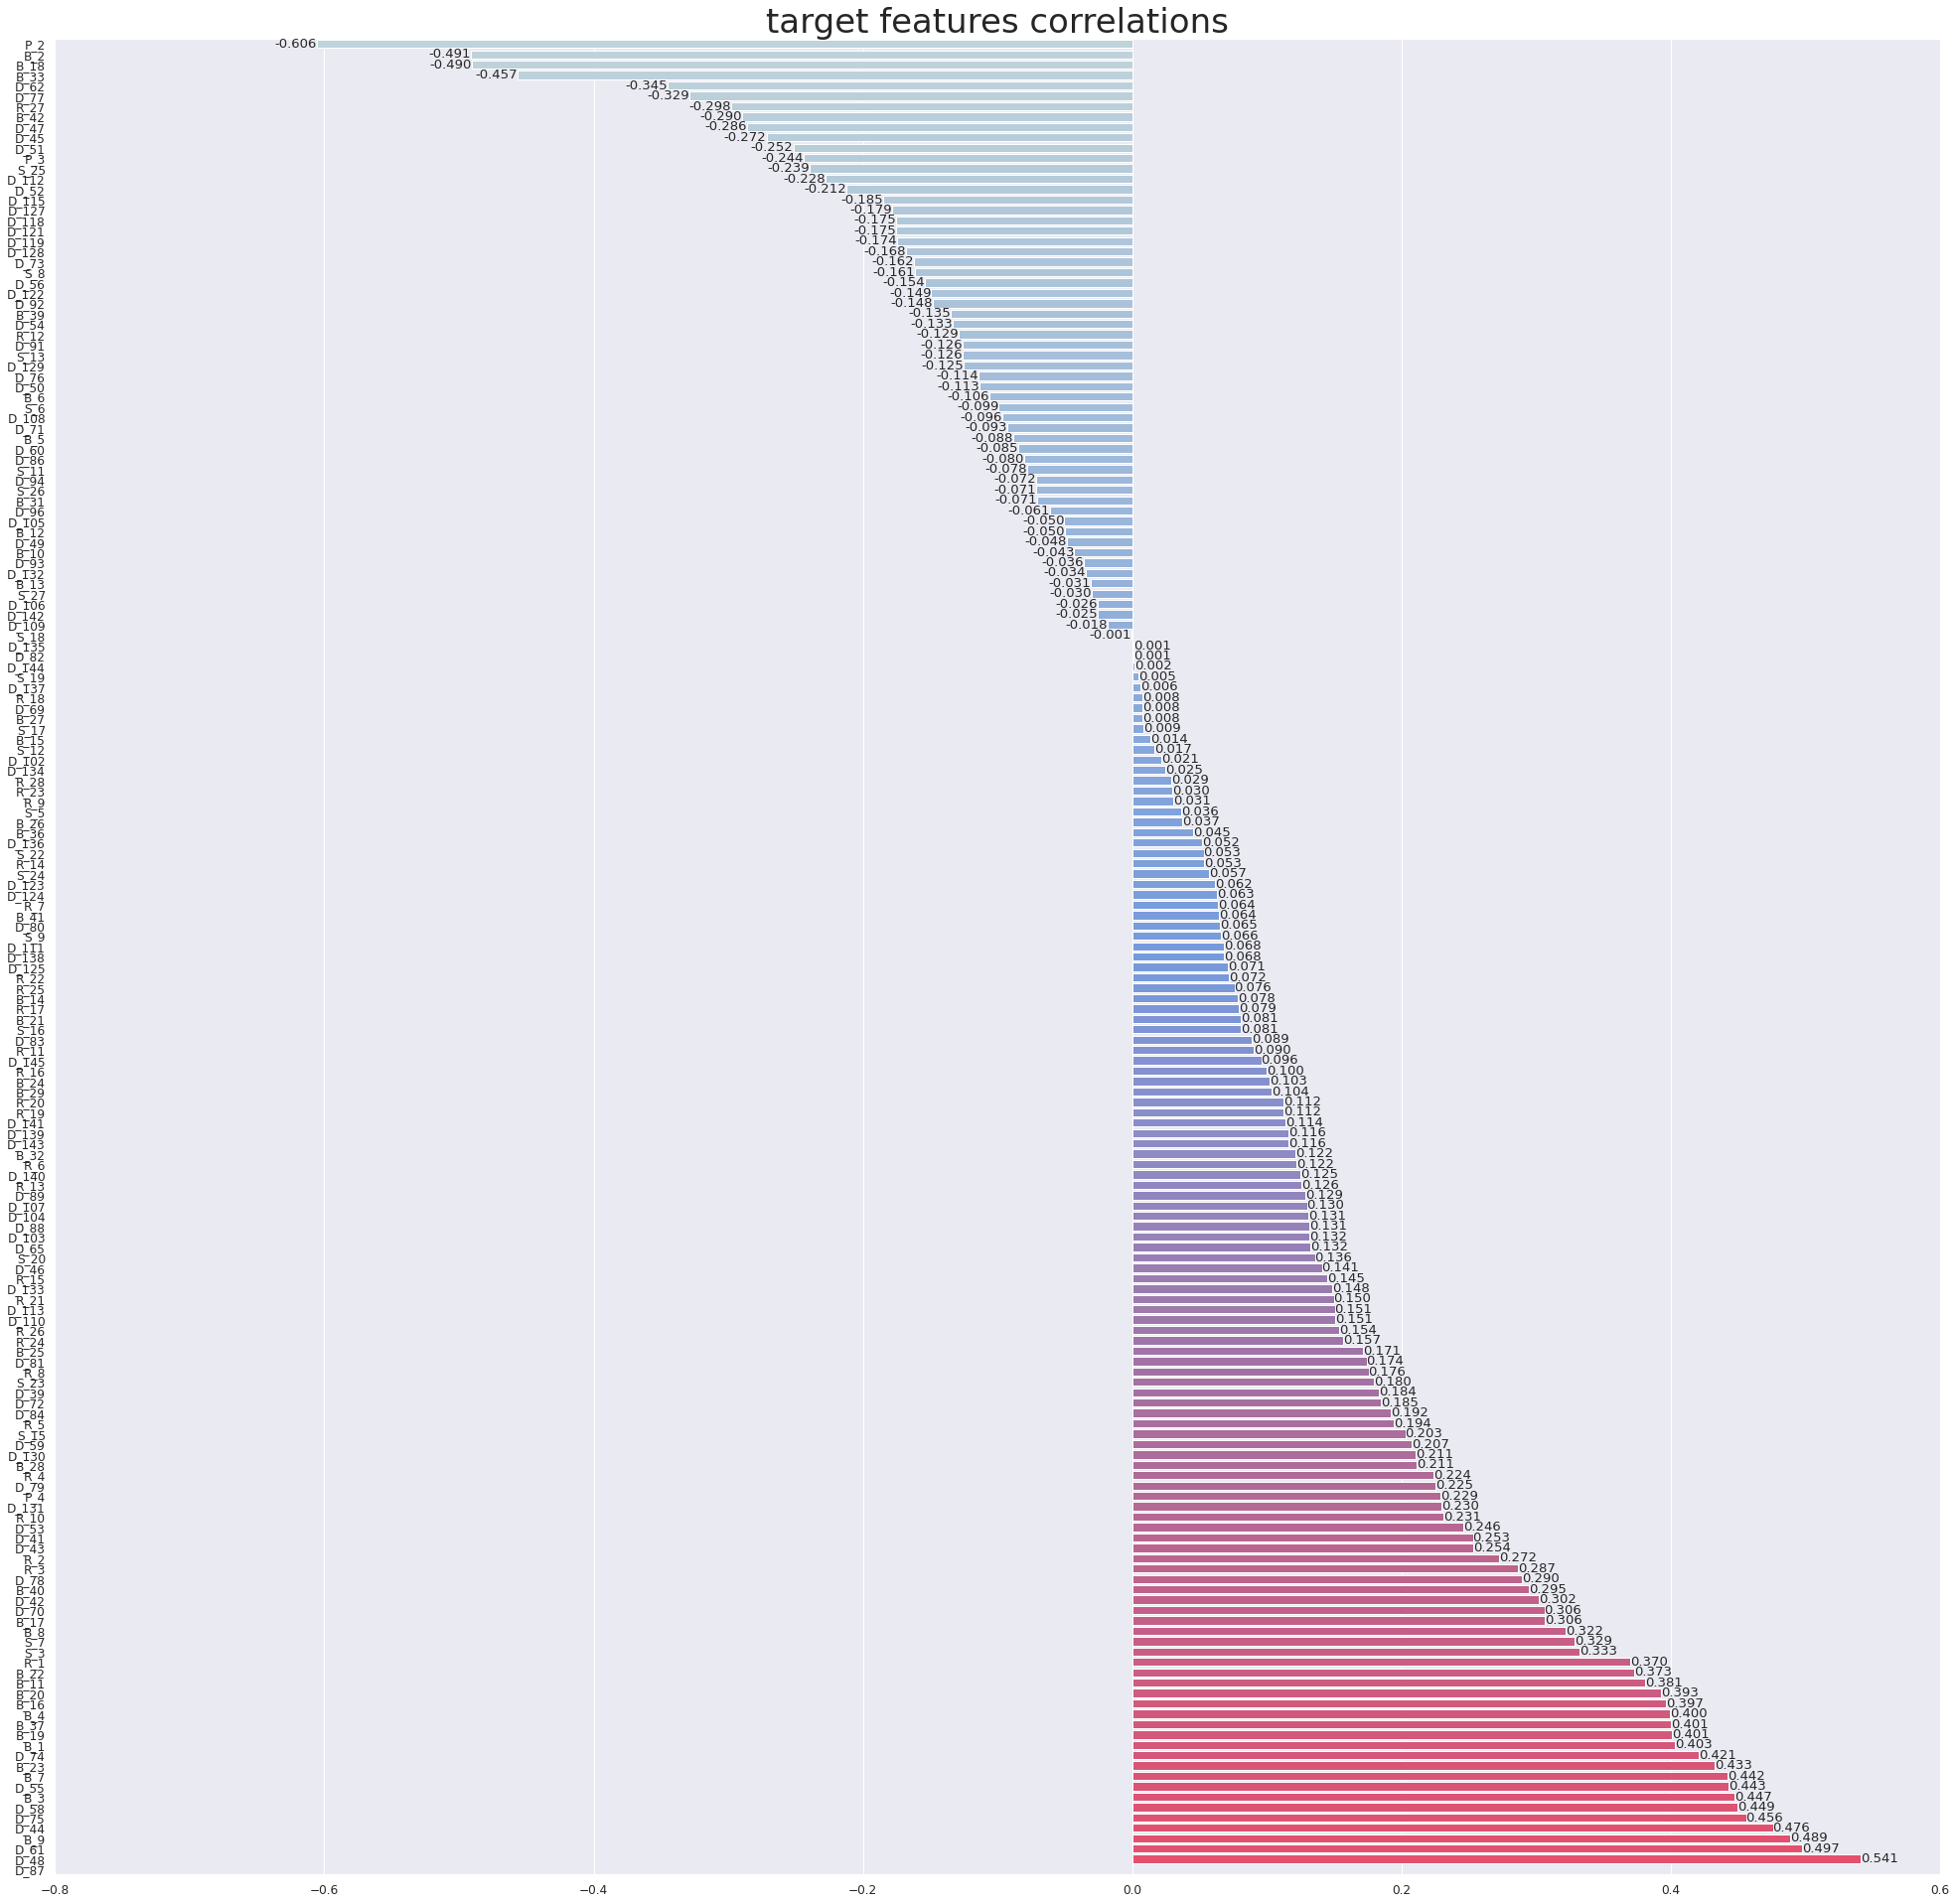

In [23]:
plot_corr(train_df,'target')